<a href="https://colab.research.google.com/github/WilliamShengYangHuang/AALU_Coding/blob/main/Text-Image_Inter-Modal_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text-Image Inter-Modal Analysis**

In [1]:
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers torch

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-nm9udqep
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-nm9udqep
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=7460fd83c5a16064fb870b0438d13330670023ca96e5a12c6029ca6f5355ad9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-nrqkae0b/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


In [3]:
import os
import torch
import clip
import matplotlib.pyplot as plt
from PIL import Image
import requests

from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor, ViTFeatureExtractor, AutoFeatureExtractor
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Set Image Path and Load Image

In [4]:
PATH = "/content/drive/My Drive/candidates/test/Asset 1" #@param{type:'string'}
FORMAT = ".png" #@param{type:'string'}
# os.listdir(PATH)

dir = PATH + FORMAT

## Load CLIP Model

In [5]:
# Load the CLIP model
model, preprocess = clip.load('ViT-B/32', device='cpu')

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 93.9MiB/s]


## Image and Text for Evaluation

In [6]:
# Load the image
image_path = str(dir)
image = preprocess(Image.open(image_path)).unsqueeze(0).to('cpu')

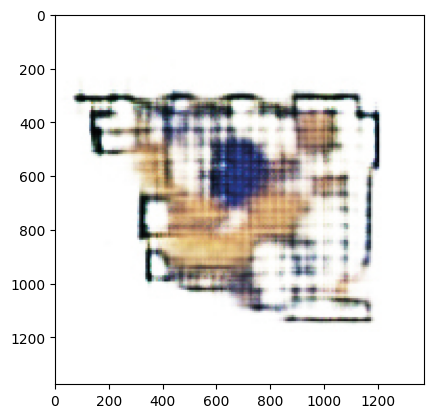

In [7]:
image = Image.open(dir)
plt.imshow(image)
plt.show()

In [8]:
text_prompt = "A building plan"
text = clip.tokenize([text_prompt]).to('cpu')

## Calculate features

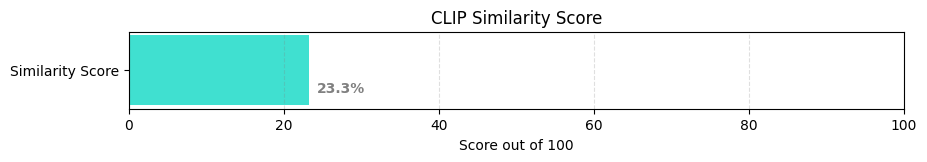

CLIP score (similarity) between the image and the text prompt: 0.23301520943641663


In [9]:
# Convert image to RGB if it's not in that format
if image.mode != 'RGB':
    image = image.convert('RGB')

    # Preprocess the image
image_tensor = preprocess(image).unsqueeze(0)  # Add a batch dimension

# Encode image and text
text = clip.tokenize(["Your text prompt here"]).to('cpu')
with torch.no_grad():
    image_features = model.encode_image(image_tensor)
    text_features = model.encode_text(text)

    # Compute the cosine similarity
    similarity = torch.nn.functional.cosine_similarity(text_features, image_features, dim=1)
    similarity_percentage = similarity * 100

    # Drawing a bar chart
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.barh(['Similarity Score'], [similarity_percentage.item()], color='turquoise')
    ax.set_xlim(0, 100)
    ax.set_xlabel('Score out of 100')
    ax.set_title('CLIP Similarity Score')
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
    for i in ax.patches:
        ax.text(i.get_width()+1, i.get_y()+0.15,
                str(round((i.get_width()), 2)) + '%',
                fontsize=10, fontweight='bold',
                color='grey')
    plt.show()

print(f"CLIP score (similarity) between the image and the text prompt: {similarity.item()}")

## Generate Image Captions

In [10]:

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ydshieh/vit-gpt2-coco-en")
model = VisionEncoderDecoderModel.from_pretrained("ydshieh/vit-gpt2-coco-en")

# Load and process the image
try:
    # Attempt to use AutoFeatureExtractor if available
    feature_extractor = AutoFeatureExtractor.from_pretrained("ydshieh/vit-gpt2-coco-en")
except AttributeError:
    # Fallback to ViTFeatureExtractor if AutoFeatureExtractor is not available
    from transformers import ViTFeatureExtractor
    feature_extractor = ViTFeatureExtractor.from_pretrained("ydshieh/vit-gpt2-coco-en")


image = Image.open(dir)

# Convert image to RGB if it's not in that format
if image.mode != 'RGB':
    image = image.convert('RGB')

inputs = feature_extractor(images=image, return_tensors="pt")



tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.34k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
# Generate captions with beam search
# Important(!!!): num_beams must be greater than num_returns
num_beams = 2  #@param{type:'slider', max:100, min:0, step:1}
num_returns = 1  #@param{type:'slider', max:100, min:0, step:1}


generated_ids = model.generate(**inputs, max_length=50, num_beams=num_beams, num_return_sequences=num_returns)
captions = [tokenizer.decode(generated_id, skip_special_tokens=True) for generated_id in generated_ids]
for caption in captions:
    print("Caption:", caption)


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Caption: an old fashioned picture of a small child's toy 
